# Data preprocessing for vector store
Researches:
* PDF to X converters
* Chunk strategies
In order to produce optimal embeddings from documents

## Notes on experiment PDF document loaders
- Does not seems that for the images OCR add much value, difficult pictures with a non-common structure.
--> May be better suited for an LLM with multimodal capabilities


### Notes on comparison OCR vs LLM for image parsing
- RapidOCR (~2 min) is much quicker than o4-mini (14 min 03s)
- RapidOCR is much cheaper (free) than o4-mini (51 K tokens, from 38K completion and 13K prompt = 0.1815 $)
- Total request is 69 (approximate total page size of 61 + 7 figures) --> while only 7 'Figures are of maybe interest', additional request because of logo at the top left.
- Pension Federation at the top may also use up considerable resources
- Images description by MUPDF do not always get inserted at the position of the image in the original document, may also be at the end of the page.

- PyMUPDF4LLM (9min 47s with o4-mini)

In [29]:
import os

# SOLVENCY_II_REGULATION_SEARCH_PERSIST_DIRECTORYDUMMY_CASE1_DATA_QUALITY_PENSION_FUNDS_PERSIST_DIRECTORY
# FILE_PATH_TO_EMBED = os.path.join("data/raw", "pension-martijn-files", "Kader Datakwaliteit - wet toekomst pensioenen.pdf.pdf")
# DIRECTORY_TO_EMBED = os.path.join("data", "raw", "pension-martijn-files")

# DIRECTORY_TO_EMBED = os.path.join("data", "raw", "test-data")
# PROJECT_NAME = "TEST-1"
# SOLVENCY_II_REGULATION_SEARCH_PERSIST_DIRECTORY

# FILE_PATH_TO_EMBED = os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf")
PROJECT_NAME = "solvency-II-files" # WILL BE USED AS REFERENCE FOR /preprocessed and /preprocessed-v2, best to have same as directory name on raw data
DIRECTORY_TO_EMBED = os.path.join("data", "raw", "solvency-II-files")

from dotenv import load_dotenv
load_dotenv()

True

### PYPDF with standard config

In [ ]:
# PYPDF DID NOT MEET REQUIREMENTS
# --> THEREFORE COMMENTED OUT
# import warnings
# import os

# # load pdf
# # from langchain_community.document_loaders import PyPDFLoader
# # loader = PyPDFLoader(FILE_PATH_TO_EMBED)

# # load directory of PDFs
# from langchain_community.document_loaders import PyPDFDirectoryLoader
# loader = PyPDFDirectoryLoader(DIRECTORY_TO_EMBED)

# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)


# print(f"LOADED DOCUMENT WITH {len(pages)} PAGES")
# if len(pages) > 50:
#     warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


# for page in pages:
#     if page.page_content == None or page.page_content == "":
#         warnings.warn("FOUND PAGES IN DOCUMENT WITHOUT PAGE_CONTENT")

LOADED DOCUMENT WITH 69 PAGES


C:\Users\bvbraak\AppData\Local\Temp\ipykernel_11668\3214218585.py:19: UserWarning: DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS
  warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


Identified issues
1. footnotes
2. neemt geen figuren mee
3. tabellen, verliest structuur
4. links worden niet meegenomen
5. verlies van layout en structuur, belangrijk met titels, artikelen etc.
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie.

### PyMuPDF with image parser and extract tables

In [29]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders.parsers.images import TesseractBlobParser, RapidOCRBlobParser, LLMImageBlobParser


load_dotenv()
# tesseract not downloaded yet as need to install executable by system admin
# images_parser = TesseractBlobParser(langs=('nld',))
# images_parser = RapidOCRBlobParser()
# model = ChatGoogleGenerativeAI(model="model/gemini-2.5-pro-exp-03-25") #did not test this one yet
model = ChatGoogleGenerativeAI(model="models/gemini-2.5-pro")
# model = AzureChatOpenAI(
#         model="o4-mini",
#         azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT_SWEDEN"],
#         api_version="2025-01-01-preview",
#         api_key=os.environ["AZURE_OPENAI_API_KEY_SWEDEN"]
#     )
print(model)


# from packages
prompt: str = (
    "You are an assistant tasked with summarizing images for retrieval. "
    "1. These summaries will be embedded and used to retrieve the raw image. "
    "Give a concise summary of the image that is well optimized for retrieval\n"
    "2. extract all the text from the image. "
    "Do not exclude any content from the page.\n"
    "Return your answer in plain text"
)

images_parser = LLMImageBlobParser(model=model, prompt=prompt)

model='models/gemini-2.5-pro' google_api_key=SecretStr('**********') client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x00000248DFFF4B90> default_metadata=()


In [ ]:
# PyMuPDF4LLM preverted over PyMuPDFLoader
# from langchain_community.document_loaders import PyMuPDFLoader

# # testing loader on entire filepath
# loader = PyMuPDFLoader(FILE_PATH_TO_EMBED, extract_images=True, images_parser=images_parser, extract_tables="markdown" )

# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)

client=<openai.resources.chat.completions.completions.Completions object at 0x0000027927C76AD0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000027927C7AE90> root_client=<openai.lib.azure.AzureOpenAI object at 0x00000279279EA490> root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000027927C76C10> model_name='o4-mini' model_kwargs={} openai_api_key=SecretStr('**********') disabled_params={'parallel_tool_calls': None} azure_endpoint='https://openai-playground-bjorn-sweden.openai.azure.com' openai_api_version='2025-01-01-preview' openai_api_type='azure'


Early identified issue with PyPDF, now partly resolved with PyMuPDF:
1. footnotes --> unresolved
2. neemt geen figuren mee --> Improved with LLM for image_parsing
3. tabellen, verliest structuur --> improved with PyMuPDF
4. links worden niet meegenomen --> unresolved (may not be as important)
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> unresolved (may be a langchain issue not investigated yet)

### PyMuPDF4LLM with image_parser and extract tables AND returning markdown
on single mode and page mode ~ 25s without image parsing


In [ ]:
# import os

# MAX_PATH = 80  # Windows traditional MAX_PATH limit

# def truncate_filename_to_fit(full_path, max_path_len=MAX_PATH):
#     """
#     Truncate the filename so that the full absolute path fits within max_path_len.
#     Keeps the file extension intact.
#     """
#     dir_name = os.path.dirname(full_path)
#     base_name = os.path.basename(full_path)
#     name, ext = os.path.splitext(base_name)

#     # Calculate allowed length for filename (including extension)
#     allowed_name_len = max_path_len - len(dir_name) - 1  # -1 for os.sep

#     # If already fits, no truncation needed
#     if len(full_path) <= max_path_len:
#         return full_path

#     # Truncate filename to fit
#     # Leave room for extension
#     allowed_name_len -= len(ext)
#     if allowed_name_len <= 0:
#         raise ValueError(f"Cannot truncate filename to fit MAX_PATH for: {full_path}")

#     truncated_name = name[:allowed_name_len]
#     new_name = truncated_name + ext
#     new_full_path = os.path.join(dir_name, new_name)
#     return new_full_path

# def rename_files_to_fit_path_length(root_dir, max_path_len=MAX_PATH):
#     for dirpath, dirnames, filenames in os.walk(root_dir):
#         for filename in filenames:
#             old_full_path = os.path.join(dirpath, filename)
#             abs_path = os.path.abspath(old_full_path)

#             if len(abs_path) > max_path_len:
#                 # try:
#                     new_full_path = truncate_filename_to_fit(abs_path, max_path_len)
#                     if not os.path.exists(new_full_path):
#                         print(f"Renaming:\n{abs_path}\nto\n{new_full_path}\n")
#                         os.rename(abs_path, new_full_path)
#                     else:
#                         print(f"Skipping rename because target exists: {new_full_path}")
#                 # except Exception as e:
#                 #     print(f"Error truncating '{abs_path}': {e}")


# dir_path = r"C:\guidelines-level 3-v0.1"
# rename_files_to_fit_path_length(dir_path)

Renaming:
C:\guidelines-level 3-v0.1\Amendments to the guidelines on the supervision of branches of third country insurance undertakings 2810 October 2022 shall apply from 31 December 2023.pdf
to
C:\guidelines-level 3-v0.1\Amendments to the guidelines on the supervision o.pdf

Renaming:
C:\guidelines-level 3-v0.1\Final report on public consultation 19-270 on guidelines on outsourcing to cloud service providers.pdf
to
C:\guidelines-level 3-v0.1\Final report on public consultation 19-270 on gui.pdf

Renaming:
C:\guidelines-level 3-v0.1\Final Report on the public consultation CP-14-047 Guidelines on reporting and disclosure.pdf
to
C:\guidelines-level 3-v0.1\Final Report on the public consultation CP-14-047.pdf

Renaming:
C:\guidelines-level 3-v0.1\Final Report on the public consultation CP-14-050 Guidelines on exchange of information on a systematic basis within colleges.pdf
to
C:\guidelines-level 3-v0.1\Final Report on the public consultation CP-14-050.pdf

Renaming:
C:\guidelines-level 

In [ ]:
import os
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
async def loadSinglePage(file_path_to_embed):
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="single", extract_images=False, table_strategy="lines_strict") 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
    return pages

single_pages = await loadSinglePage(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf"))

FINISHED LOADING DOCUMENT data\raw\solvency-II-files\solvency II - level 1 - v2.pdf: 1


In [10]:
import os
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
async def loadPage(file_path_to_embed):
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="page", extract_images=False, table_strategy="lines_strict") 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
    return pages

pages = await loadPage(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf"))

FINISHED LOADING DOCUMENT data\raw\solvency-II-files\solvency II - level 1 - v2.pdf: 155


In [27]:
import re

_DEFAULT_PAGES_DELIMITER = "\n-----\n\n"
page_delimiters = re.findall(r"\n-----\n\n", single_pages[0].page_content)
single_pages[0].metadata["total_pages"] - 1 == len(page_delimiters)

True

In [19]:
pages[0].__dict__

{'id': None,
 'metadata': {'producer': 'Adobe PDF Library 5.0.2',
  'creator': '',
  'creationdate': '2009-12-14T11:27:02+00:00',
  'source': 'data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf',
  'file_path': 'data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf',
  'total_pages': 155,
  'format': 'PDF 1.4',
  'title': 'Directive 2009/138/EC of the European Parliament and of the Council of 25 November 2009 on the taking-up and pursuit of the business of Insurance and Reinsurance (Solvency II)',
  'author': 'Publications Office',
  'subject': '',
  'keywords': '',
  'moddate': '2009-12-14T15:51:53+01:00',
  'trapped': '',
  'modDate': "D:20091214155153+01'00'",
  'creationDate': 'D:20091214112702Z',
  'page': 0},
 'page_content': '11.72.2009 EN\n\n\n\nOfficial Journ al of the E uropean Un ion L 335/1\n\n## I\n\n\n_(Acts adopted under the EC Treaty/Euratom Treaty whose publication is obligatory)_\n\n## DIRECTIVES\n\n\n\n**DIRECTIVE 2009/138/EC OF THE EUROPEAN PARLIAME

In [17]:
for page in pages:
    print(page.metadata["page"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


In [ ]:
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
import re
import urllib.parse
import pickle
import datetime

# https://pymupdf.readthedocs.io/en/latest/page.html#Page.find_tables
# Request a table detection strategy. Valid values are “lines”, “lines_strict” and “text”.
# Default is “lines” which uses all vector graphics on the page to detect grid lines.
# Strategy “lines_strict” ignores borderless rectangle vector graphics. Sometimes single text pieces have background colors which may lead to false columns or lines. This strategy ignores them and can thus increase detection precision.
# If “text” is specified, text positions are used to generate “virtual” column and / or row boundaries. Use min_words_* to request the number of words for considering their coordinates.
# Use parameters vertical_strategy and horizontal_strategy instead for a more fine-grained treatment of the dimensions.

# DEBUG_FILE_PATH_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging", "10-page-data-kwaliteit.pdf")
# DEBUG_DIRECTORY_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging")
#PyMuPDF4LLMLoader(DEBUG_FILE_PATH_TO_EMBED, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict")

async def loadPage(file_path_to_embed):
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict") 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
    return pages


documents = {}
# loading files synchronously, may benefit from doing this asynchronous later
APPROX_MAX_PATH = 256
directory = DIRECTORY_TO_EMBED
size_check_sum = 0
for file_name in os.listdir(directory):
    print(f"LOADING AT FILE/DIRECTORY {file_name}...")
    file_path_to_embed = os.path.join(directory, file_name)

    if os.path.isdir(file_path_to_embed):
        for file_name in os.listdir(file_path_to_embed):
            # encoded_file_name = urllib.parse.quote(file_name)
            actual_file_path_to_embed = os.path.join(file_path_to_embed, file_name)
            print(os.path.abspath(actual_file_path_to_embed))
            print(len(os.path.abspath(actual_file_path_to_embed)))
            if os.name == "nt" and len(os.path.abspath(actual_file_path_to_embed)) > APPROX_MAX_PATH:
                # max path problem in windows, f windows....
                raise Exception(F"{APPROX_MAX_PATH} is max path length loading will fail")
            # check
            pages = await loadPage(actual_file_path_to_embed)
            documents[file_name] = pages
            size_check_sum += 1
    elif os.path.isfile(file_path_to_embed):
        if os.name == "nt" and len(os.path.abspath(file_path_to_embed)) > APPROX_MAX_PATH:
            Warning(F"{APPROX_MAX_PATH} is max path length loading will fail")
        print(f"LOADING DOCUMENT {file_name}...")
        pages = await loadPage(file_path_to_embed)
        documents[file_name] = pages
        size_check_sum += 1
    else:
        raise Exception("Not Implemented")

print(f"FINISHED LOADING: {len(documents)}")
print(f"IS SUCCESS? {len(documents)}, {size_check_sum} : {len(documents) == size_check_sum}")

LOADING AT FILE/DIRECTORY guidelines-level 3-v0.1 - TRUNCATED...
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Consolidated_GLs_CBs_ET_EN.pdf
161
FINISHED LOADING DOCUMENT Consolidated_GLs_CBs_ET_EN.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\EIOPA-BoS-14-259_Final report_ORSA.pdf
169
FINISHED LOADING DOCUMENT EIOPA-BoS-14-259_Final report_ORSA.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Guidelines on basis risk.pdf
159
FINISHED LOADING DOCUMENT Guidelines on basis risk.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Guidelines on Classification of Own Funds.pdf
176
FINISHED LOADING DOCUMENT Guidelines on Classification of Own Fu

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


FINISHED LOADING DOCUMENT Joint Guidelines on Risk Factors.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Privacy Statement - ESAs Information System.pdf
178
FINISHED LOADING DOCUMENT Privacy Statement - ESAs Information System.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Revised Guidelines on Contract Boundaries.pdf
176
FINISHED LOADING DOCUMENT Revised Guidelines on Contract Boundaries.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Technical Annexes.pdf
152
FINISHED LOADING DOCUMENT Technical Annexes.pdf: 1
LOADING AT FILE/DIRECTORY solvency II - level 1 - v2.pdf...
LOADING DOCUMENT solvency II - level 1 - v2.pdf...
FINISHED LOADING DOCUMENT solvency II - level 1 - v2.pdf: 1
LOADING AT FILE/DIRECTORY solvency II -

In [32]:
import datetime
import pickle
from langchain_core.documents import Document

# documents = [
#     Document(page_content="This is the first document.", metadata={"source": "file1.pdf", "page": 1}),
#     Document(page_content="This is the second document.", metadata={"source": "file2.pdf", "page": 1})
# ]

print(f"SAVING RESULTS....: {len(documents)}")
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# FILE_EXTENSION = ".md"
OUTPUT_PICKLE_FILE_NAME = f"{PROJECT_NAME}-docs-{timestamp}"
# Now, save the entire list of Document objects to a file
file_path = os.path.join("data", "intermediate-save", OUTPUT_PICKLE_FILE_NAME + ".pkl")
with open(file_path, 'wb') as f:
    pickle.dump(documents, f)

print(f"\nSuccessfully saved {len(documents)} Document objects to:")
print(OUTPUT_PICKLE_FILE_NAME) # Print the exact filename for future reference

SAVING RESULTS....: 23

Successfully saved 23 Document objects to:
solvency-II-files-docs-2025-07-16_18-04-58


Early identified issue with PyPDF, partly resolved with PyMuPDF, and PyMuPDF4LLM:
1. footnotes included, but not inserted at place of footnote, but where they are located (so llm will not understand) --> unresolved
2. neemt geen figuren mee -->  [PyMuPDF] Improved with LLM for image_parsing
3. tabellen, verliest structuur --> [PyMuPDF] Improved with PyMuPDF
4. links worden niet meegenomen --> [PyMuPDF4LLM] Resolved with markdown formatting
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved --> [PyMuPDF4LLM] Improved with markdown formatting
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> [PyMuPDF] mode='single'

Test concluded:
The test were performed one pdf, namely Kader Datakwaliteit - wet toekomst pensioenen.pdf.
Based on the experiment issues were identified with converting pdf to raw text. Fix all identified issues excluding footnote, which is not the most important issue to focus on as likely adds little value.

Future direction:

Interesting parser may be, which also let's you parse different types of documents, now the pipeline only handles .pdfs
* https://www.llamaindex.ai/llamaparse
* https://unstructured.io/

In addition significant speed up by just remove logo on the top left in document (repeating information)

### notes on small technical change
small technical problem when using a markdown header splitter, e.g.
images distort the headers, so should not give markdown format within image description:

![## Summary Logo for “Pensioen Federatie” featuring the organization’s name in uppercase letters with stylized golden arcs.

Extracted Text
PENSIOEN
FEDERATIE](#)

#### IMPLEMENTED CHANGE
Slightly adjusted the instruction for llm-based image_parser to not return plain text

### Docling

In [ ]:
# from langchain_docling import DoclingLoader

# FILE_PATH = "https://arxiv.org/pdf/2408.09869"
# file_path = FILE_PATH_TO_EMBED

# loader = DoclingLoader(file_path=file_path, export_type="markdown")

In [ ]:
# docs = loader.load()

# for d in docs[:3]:
#     print(f"- {d.page_content=}")

c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


- d.page_content="DATUM:  11 oktober 2022 ONDERWERP: Kader Datakwaliteit KENMERK: D/2022/718/OH\n\n## Kader Datakwaliteit -Wet Toekomst Pensioenen\n\nPensioenfederatie Prinses Margrietplantsoen 90 2595 BR Den Haag Postbus 93158 2509 AD Den Haag T +31 (0)70 76 20 220 info@pensioenfederatie.nl www.pensioenfederatie.nl\n\nKvK Haaglanden 52988368\n\n## Inhoudsopgave\n\n| 1.                                                                                  | INLEIDING KADER DATAKWALITEIT                                                       |   4 |\n|-------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|-----|\n| 2.                                                                                  | OVERZICHT KADER DATAKWALITEIT                                                       |   8 |\n| 3.                                                                                  | F

In [ ]:
# for file_name, pages in {file_path.split("\\")[-1]: docs}.items():
#     if len(pages) == 1: #only for single pages returned
#         document = pages[0] #very prone to bugs, must be a better way
#     else:
#         raise Exception("not implemented yet")
    
#     with open(os.path.join("data/preprocessed/experimental/20250503-DOCLING/pension-martijn-files", file_name + ".md"), 'w', encoding='utf-8') as f:
#         f.write(document.page_content)

In [ ]:
# print(docs[10].__dict__.keys())
# print(docs[7].page_content)

# for doc in docs:
#     print(doc.type)

dict_keys(['id', 'metadata', 'page_content', 'type'])
Layout Analysis Model
Our layout analysis model is an object-detector which predicts the bounding-boxes and classes of various elements on the image of a given page. Its architecture is derived from RT-DETR [16] and re-trained on DocLayNet [13], our popular human-annotated dataset for document-layout analysis, among other proprietary datasets. For inference, our implementation relies on the onnxruntime [5].
The Docling pipeline feeds page images at 72 dpi resolution, which can be processed on a single CPU with sub-second latency. All predicted bounding-box proposals for document elements are post-processed to remove overlapping proposals based on confidence and size, and then intersected with the text tokens in the PDF to group them into meaningful and complete units such as paragraphs, section titles, list items, captions, figures or tables.
Document
Document
Document
Document
Document
Document
Document
Document
Document
Document
D

# Save standard preprocessed with PyMuPDF4LLM

In [ ]:
# # remove any logo image from the markdown, to allow for better readability of tables
# # did not test yet if it actualy produces better readable tables,
# # paginations still seems to be in the way,
# # also loked at doing this pre image_parser to not invoke cost
# # however, did not find to do it with the package, so skipped that
# # quick fix is this.
# import re
# directory = os.path.join("data", "preprocessed", PROJECT_NAME)
# new_directory =  os.path.join("data", "preprocessed-v2", PROJECT_NAME)
# for file_name in os.listdir(directory):
#     with open(os.path.join(directory, file_name), "r", encoding='utf-8') as f:
#         page_content = f.read()
#         regex = r"(?i)!\[([^\]]*?logo[^\]]*?)\]\(.*?\)" # case insenstive match for logo in summary
#         new_page_content = re.sub(regex, "", page_content)

#     with open(os.path.join(new_directory, file_name), "w", encoding='utf-8') as f_new:
#         f_new.write(new_page_content)

In [76]:
def print_document_page(page):
    correction_index = 1 #differ per pdf converter, also have different metadata
    print(f"--- source {page.metadata["source"].split("\\")[-1]} ---")
    print(f"--- page {page.metadata["page"] + correction_index} / {page.metadata["total_pages"]} ---")
    print(page)
    print("---end of page")


# for page in pages[:61]:
#     print_document_page(page)

# for page in pages[61:105]:
#     print_document_page(page)

# for page in pages[105:]:
#     print_document_page(page)

## Notes on chunking strategy
### Markdown formatting not preserved by MarkdownTextSplitter
#### Resolution
Switched from MarkdownTextSplitter
to 
ExperimentalMarkdownSyntaxTextSplitter

main reason was newlines were removed within the markdown for no apperent reason,
which broke formatting e.g. with

42

----

becoming

This is a all bold
42
-----

Which is just \n characters which are removed from the original file

```
This is a all bold
42
-----
```

### Table being cut in middle of chunk
* Additionally I had problems with tables getting cut of, not sure if resolved yet, e.g. if it is recusrivetextsplitter problem, markdowntextsplitter, or combination.


### Multipage table not being interpret correct through the markdown
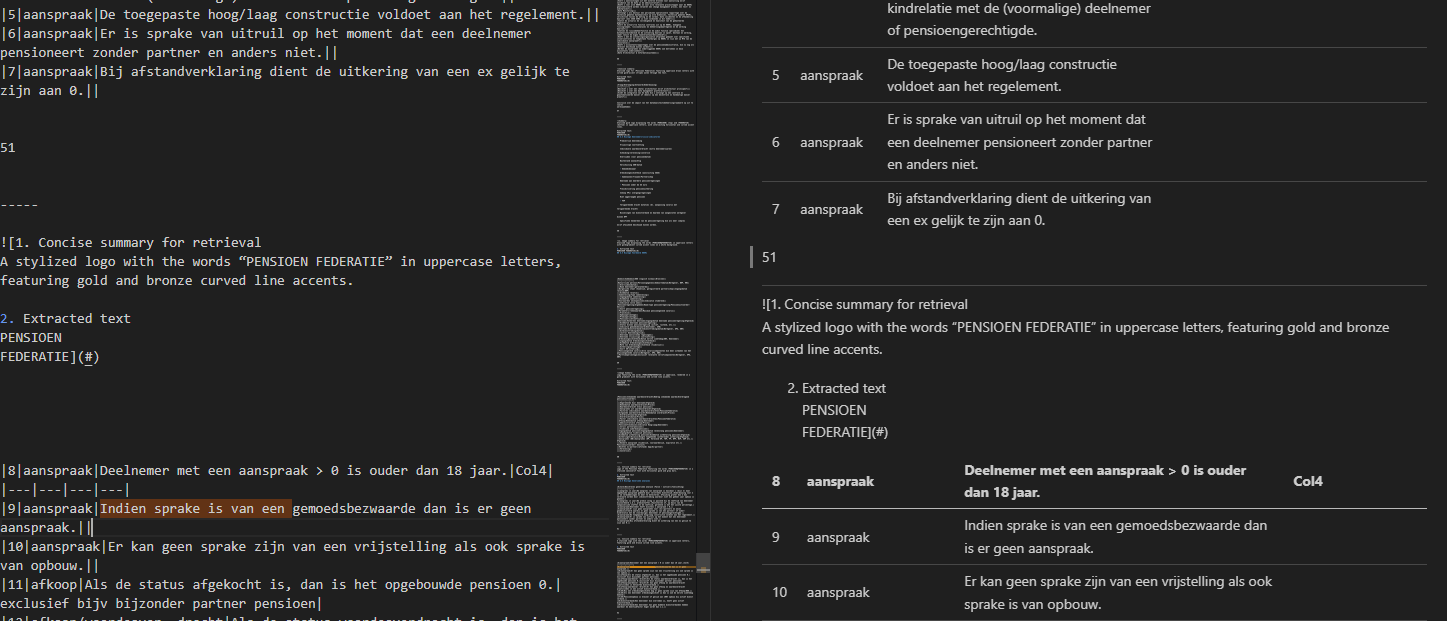

### Textsplitters

#### Using basic textsplitter on pagened documents

#### Using markdown textsplitter on single document

In [23]:
for filename, document in documents.items():
    print(filename)
    print(documents[filename])
    print(len(document))

Master_Thesis-small.pdf
[Document(metadata={'producer': 'Microsoft: Print To PDF', 'creator': '', 'creationdate': '2025-07-16T12:32:04+02:00', 'source': 'data\\raw\\test-data\\Master_Thesis-small.pdf', 'file_path': 'data\\raw\\test-data\\Master_Thesis-small.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': 'Master_Thesis (6).pdf', 'author': 'Björn van Braak', 'subject': '', 'keywords': '', 'moddate': '2025-07-16T12:32:04+02:00', 'trapped': '', 'modDate': "D:20250716123204+02'00'", 'creationDate': "D:20250716123204+02'00'"}, page_content='![This is an abstract of a thesis about using Large Language Models (LLMs) and Retrieval-Augmented Generation (RAG) to improve actuarial productivity. It proposes a methodological framework for designing and implementing RAG systems to help actuaries in pension funds and insurance companies navigate complex regulations like Solvency II and IFRS 17. The research includes a Proof-of-Concept for Solvency II regulatory search, demonstrating the potenti

In [ ]:
# documents

# print(loaded_docs)
# for doc in loaded_docs:
#     print(loaded_docs[doc])
# # loaded_docs

for filename, original_doc in loaded_docs.items():
    print(filename)
    print(original_doc)


Master_Thesis-small.pdf
[Document(metadata={'producer': 'Microsoft: Print To PDF', 'creator': '', 'creationdate': '2025-07-16T12:32:04+02:00', 'source': 'data\\raw\\test-data\\Master_Thesis-small.pdf', 'file_path': 'data\\raw\\test-data\\Master_Thesis-small.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': 'Master_Thesis (6).pdf', 'author': 'Björn van Braak', 'subject': '', 'keywords': '', 'moddate': '2025-07-16T12:32:04+02:00', 'trapped': '', 'modDate': "D:20250716123204+02'00'", 'creationDate': "D:20250716123204+02'00'"}, page_content='![This is an abstract of a thesis about using Large Language Models (LLMs) and Retrieval-Augmented Generation (RAG) to improve actuarial productivity. It proposes a methodological framework for designing and implementing RAG systems to help actuaries in pension funds and insurance companies navigate complex regulations like Solvency II and IFRS 17. The research includes a Proof-of-Concept for Solvency II regulatory search, demonstrating the potenti

In [15]:
print(type(loaded_docs[0]))

KeyError: 0

In [2]:
import pickle
import os
# load in document objects
SAVE_DIRECTORY = os.path.join("data", "intermediate-save")

# You must replace this with the actual filename from the save step
filename_to_load = "solvency-II-files-docs-2025-07-16_18-04-58.pkl"
filepath_to_load = os.path.join(SAVE_DIRECTORY, filename_to_load)

with open(filepath_to_load, 'rb') as f:
    loaded_docs = pickle.load(f)


# reasoning for mode = single is because of markdowntextsplitter used, therefore each page is the entire document
# save pdf documents which are transformed in markdown format with mode = "single" to seperate files 
for file_name, pages in loaded_docs.items():
    if len(pages) == 1: #only for single pages returned
        document = pages[0] #very prone to bugs, must be a better way
        loaded_docs[file_name] = document
    else:
        raise Exception("not implemented yet")
    

    # with open(os.path.join("data", "preprocessed", PROJECT_NAME, file_name + ".md"), 'w', encoding='utf-8') as f:
    #     f.write(document.page_content)

print(f"Successfully loaded {len(loaded_docs)} documents from {filepath_to_load}")
# ... proceed with your splitting logic

Successfully loaded 23 documents from data\intermediate-save\solvency-II-files-docs-2025-07-16_18-04-58.pkl


In [ ]:
# '17.1.2015 EN Official Journal of the European Union L 12/5\n'

for filename, original_doc in loaded_docs.items():
    print(f"\nName:\"{filename}\"")
    print(f"Title: \"{original_doc.metadata['title']}\"\n")


Name:"Consolidated_GLs_CBs_ET_EN.pdf"
Title: "Guidelines on Contract Boundaries – Consolidated Version with Explanatory Text"


Name:"EIOPA-BoS-14-259_Final report_ORSA.pdf"
Title: ""


Name:"Guidelines on basis risk.pdf"
Title: ""


Name:"Guidelines on Classification of Own Funds.pdf"
Title: ""


Name:"Guidelines on group solvency.pdf"
Title: ""


Name:"Guidelines on health catastrophe risk sub-module.pdf"
Title: ""


Name:"Guidelines on look-through approach.pdf"
Title: ""


Name:"Guidelines on operational functioning of colleges.pdf"
Title: ""


Name:"Guidelines on Own Risk Solvency Assessment .pdf"
Title: ""


Name:"Guidelines on reporting and public disclosure.pdf"
Title: ""


Name:"Guidelines on ring-fenced funds.pdf"
Title: ""


Name:"Guidelines on supervisory review process.pdf"
Title: ""


Name:"Guidelines on the use of internal models.pdf"
Title: ""


Name:"Guidelines on undertaking-specific parameters.pdf"
Title: ""


Name:"JC 2024-34_Guidelines on costs and losses_DORA.pdf

In [ ]:
# clean up the headers, clean up the images

# adding additional metadata to the document
def get_short_title(filename: str):
    filename_to_short_title = {
    "Consolidated_GLs_CBs_ET_EN.pdf": "CB Guidelines (Consolidated)",
    "EIOPA-BoS-14-259_Final report_ORSA.pdf": "ORSA Final Report",
    "Guidelines on basis risk.pdf": "Basis Risk Guidelines",
    "Guidelines on Classification of Own Funds.pdf": "Own Funds Classification",
    "Guidelines on group solvency.pdf": "Group Solvency Guidelines",
    "Guidelines on health catastrophe risk sub-module.pdf": "Health Cat Risk Guidelines",
    "Guidelines on look-through approach.pdf": "Look-through Approach",
    "Guidelines on operational functioning of colleges.pdf": "Colleges Operational Guidelines",
    "Guidelines on Own Risk Solvency Assessment .pdf": "ORSA Guidelines",
    "Guidelines on reporting and public disclosure.pdf": "Reporting & Disclosure Guidelines",
    "Guidelines on ring-fenced funds.pdf": "Ring-fenced Funds Guidelines",
    "Guidelines on supervisory review process.pdf": "Supervisory Review Guidelines",
    "Guidelines on the use of internal models.pdf": "Internal Models Guidelines",
    "Guidelines on undertaking-specific parameters.pdf": "USP Guidelines",
    "JC 2024-34_Guidelines on costs and losses_DORA.pdf": "DORA Costs & Losses Guidelines",
    "Joint ESA Final Report on Art 97 Guidelines MiCAR.pdf": "MiCAR Art. 97 Final Report",
    "Joint ESA Gls MiCAR %28JC 2024 28%29_EN.pdf": "MiCAR Joint Guidelines (JC 2024/28)",
    "Joint Guidelines on Risk Factors.pdf": "Risk Factors Guidelines",
    "Privacy Statement - ESAs Information System.pdf": "ESA Privacy Statement",
    "Revised Guidelines on Contract Boundaries.pdf": "CB Guidelines (Revised)",
    "Technical Annexes.pdf": "Technical Annexes",
    "solvency II - level 1 - v2.pdf": "Solvency II – Level 1 Directive",
    "solvency II - level 2.pdf": "Solvency II – Level 2 Regulation"
    }
    if not filename in filename_to_short_title:
        print(f"[Warning] No short title found for {filename}")
        raise Exception("Please include filename: short_title")
    
    return filename_to_short_title[filename]

# replace page delimiter with page number + page delimiter

for filename, original_doc in loaded_docs.items():
    # short_title
    original_doc.metadata["short_title"] = get_short_title(original_doc.metadata["source"].split("\\")[-1])
    # document_id
    # source_type / level
    # document description
    # language?
    # preprocessing description
    # importance_score
    # entities
    # jurisdiction
    # topics
    # 


    # chunks:
    # legal_referencesh --> also verifies if markdown_splitter works correctly

In [63]:
for filename in loaded_docs:
    # print(loaded_docs[filename].metadata["short_title"])
    print(repr(loaded_docs[filename].metadata))

{'producer': 'Adobe PDF Library 22.3.86', 'creator': 'Acrobat PDFMaker 22 for Word', 'creationdate': '2023-03-10T09:04:19+01:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'file_path': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'total_pages': 18, 'format': 'PDF 1.6', 'title': 'Guidelines on Contract Boundaries – Consolidated Version with Explanatory Text', 'author': 'Miguel Caballero', 'subject': '', 'keywords': '', 'moddate': '2023-03-10T09:04:32+01:00', 'trapped': '', 'modDate': "D:20230310090432+01'00'", 'creationDate': "D:20230310090419+01'00'", 'short_title': 'CB Guidelines (Consolidated)'}
{'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2015-07-09T10:56:50+02:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\EIOPA-BoS-14-259_Final report_ORSA.pdf', 'file_path': 'data\\raw\\solvency-

In [14]:
import re
def preprocess_text_to_markdown(text: str) -> str:
    """
    Converts the structured text of the EU Directive into a proper Markdown format
    that the ExperimentalMarkdownSyntaxTextSplitter can understand.
    """
    # Remove page separators and other OCR artifacts
    (processed_text, num_page_separators)  = re.subn(r'\n-----\n', '\n\n', text) # Replace page breaks with paragraph breaks
    print(f"Removed {num_page_separators} page separators")

    # remove headers
    (processed_text, num_header_page)  = re.subn(r'\nL \d{3}/\d{1,3} EN\n', '\n', processed_text)
    print(f"Removed {num_header_page} header pages")
    (processed_text, num_header_title) = re.subn(r'Official Journ al of the E uropean Un ion \d{1,2}\.\d{1,2}\.\d{4}\n', '', processed_text)
    print(f"Removed {num_header_title} header titles")

    # Normalize italicized Articles to a consistent format for regex
    processed_text = re.sub(r'^\*(Article\s+\d+[a-z]?)\*$', r'\1', processed_text, flags=re.MULTILINE)

    # Convert structural elements to Markdown headers.
    # The order of these rules is important.
    # https://www.oreilly.com/library/view/regular-expressions-cookbook/9780596802837/ch06s09.html
    roman_numerals = "(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})"
    replacements = [
        # Match "TITLE I", "TITLE IV", etc.
        (r"^(TITLE\s+" + roman_numerals + ")$", r"# \1"),
        # Match "CHAPTER I", "CHAPTER IX", etc.
        (r"^(\*CHAPTER\s+" + roman_numerals + "\*)$", r"## \1"),
        # Match "SECTION 1", "SECTION 5", etc.
        (r"^(SECTION\s+\d+)", r"### \1"),
        # Match "Subsection 1", "Subsection 2", etc.
        (r"^(Subsection\s+\d+)$", r"#### \1"),
        # Match "Article 1", "Article 17a", etc.
        (r"^(Article\s+\d+[a-z]?)$", r"##### \1"),
    ]

    for pattern, replacement in replacements:
        processed_text = re.sub(pattern, replacement, processed_text, flags=re.MULTILINE)

    return processed_text
file_name = "solvency II - level 1 - v2.pdf"
processed_text = preprocess_text_to_markdown(text=loaded_docs[file_name].page_content)

with open(os.path.join("data", "preprocessed-step-2", file_name + ".md"), 'w', encoding='utf-8') as f:
    f.write(processed_text)

Removed 154 page separators
Removed 62 header pages
Removed 64 header titles


<>:28: SyntaxWarning: invalid escape sequence '\*'
<>:28: SyntaxWarning: invalid escape sequence '\*'
C:\Users\bvbraak\AppData\Local\Temp\ipykernel_22820\69382965.py:28: SyntaxWarning: invalid escape sequence '\*'
  (r"^(\*CHAPTER\s+" + roman_numerals + "\*)$", r"## \1"),


In [72]:
processed_text

'11.72.2009 EN\n\n\nOfficial Journ al of the E uropean Un ion L 335/1\n## I\n\n\n*(Acts adopted under the EC Treaty/Euratom Treaty whose publication is obligatory)*\n## DIRECTIVES\n\n\n**DIRECTIVE 2009/138/EC OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL**\n\n**of 25 November 2009**\n\n**on the taking-up and pursuit of the business of Insurance and Reinsurance (Solvency II)**\n\n**(recast)**\n\n**(Text with EEA relevance)**\n\n\nTHE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EURO\xad\nPEAN UNION,\n\nHaving regard to the Treaty establishing the European Commu\xad\nnity, and in particular Article 47(2) and Article 55 thereof,\n\nHaving regard to the proposal from the Commission,\n\nHaving regard to the opinion of the European Economic and\nSocial Committee ( [1] ),\n\nAfter consulting the Committee of the Regions,\n\nActing in accordance with the procedure laid down in Article 251\nof the Treaty ( [2] ),\n\nWhereas:\n\n\n(1) A number of substantial changes are to be made to First\nCounci

In [ ]:
import os
from langchain_text_splitters.markdown import ExperimentalMarkdownSyntaxTextSplitter
# from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from copy import deepcopy



# with open(os.path.join("./experiment-output", "pypdf4llm-on-data-quality-output-SINGLE-v2.md"), 'r', encoding='utf-8') as f:
#     markdown_file = f.read()


# SHOULD CHANGE SOMETHING HERE, ADDITIONAL ARTICLE HEADERS.
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

# Recitals
headers_to_split_on_v2 = [
    ("TITLE")
]

# DIRECTORY_TO_EMBED_V2 = os.path.join("data", "preprocessed-v2", PROJECT_NAME) #--> with logos removed
DIRECTORY_TO_EMBED = os.path.join("data", "preprocessed", PROJECT_NAME)

# directory = DIRECTORY_TO_EMBED
# all_markdown_splits = []
# for file_name in os.listdir(directory):
#     with open(os.path.join(directory, file_name), 'r', encoding='utf-8') as f:
#         print(f"READING FILE {file_name}")
#         markdown_file = f.read()
#         markdown_splits = ExperimentalMarkdownSyntaxTextSplitter(headers_to_split_on=headers_to_split_on).split_text(markdown_file)
#         print(f"Resulting splits {len(markdown_splits)}\n")
#         all_markdown_splits.extend(markdown_splits)
# print(f"Number of markdown splits made {len(all_markdown_splits)} vs number of orginal documents {len(os.listdir())}")

markdown_splitter = ExperimentalMarkdownSyntaxTextSplitter(
    headers_to_split_on=headers_to_split_on
)

markdown_split_documents = []

for filename, original_doc in #loaded_docs.items():
    print(f"READING FILE {original_doc.metadata}")
    # This returns a list of NEW documents that ONLY have header metadata.
    new_splits = markdown_splitter.split_text(original_doc.page_content)
    
    print(f"Resulting splits {len(new_splits)}\n")
    for split in new_splits:
        combined_metadata = deepcopy(original_doc.metadata)
        combined_metadata.update(split.metadata)
        
        markdown_split_document = Document(
            page_content=split.page_content,
            metadata=combined_metadata
        )
        
        markdown_split_documents.append(markdown_split_document)

print(f"Number of markdown splits made {len(markdown_split_documents)} vs number of orginal documents {len(loaded_docs)}")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,   # Each chunk will be 1000 characters
    chunk_overlap=200  # Overlap of 200 characters between chunks
)

chunks = text_splitter.transform_documents(markdown_split_documents)
# markdown_header_splits = markdown_splitter.split_documents(loaded_docs)

print(f"Number of {len(chunks)} chunks vs markdown splits made {len(markdown_split_documents)} ")

READING FILE {'producer': 'Adobe PDF Library 22.3.86', 'creator': 'Acrobat PDFMaker 22 for Word', 'creationdate': '2023-03-10T09:04:19+01:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'file_path': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'total_pages': 18, 'format': 'PDF 1.6', 'title': 'Guidelines on Contract Boundaries – Consolidated Version with Explanatory Text', 'author': 'Miguel Caballero', 'subject': '', 'keywords': '', 'moddate': '2023-03-10T09:04:32+01:00', 'trapped': '', 'modDate': "D:20230310090432+01'00'", 'creationDate': "D:20230310090419+01'00'"}
Resulting splits 18

READING FILE {'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2015-07-09T10:56:50+02:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\EIOPA-BoS-14-259_Final report_ORSA.pdf', 'file_path': 'data\\raw\\solvency-

In [70]:
for split in markdown_split_documents[-900:-800]:
    # print(f"- {split.page_content=}, {splt.metadata=}")
    # print(repr(split.metadata))
    print(repr(split.metadata))

{'producer': 'Adobe PDF Library 5.0.2', 'creator': '', 'creationdate': '2009-12-14T11:27:02+00:00', 'source': 'data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf', 'file_path': 'data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf', 'total_pages': 155, 'format': 'PDF 1.4', 'title': 'Directive 2009/138/EC of the European Parliament and of the Council of 25 November 2009 on the taking-up and pursuit of the business of Insurance and Reinsurance (Solvency II)', 'author': 'Publications Office', 'subject': '', 'keywords': '', 'moddate': '2009-12-14T15:51:53+01:00', 'trapped': '', 'modDate': "D:20091214155153+01'00'", 'creationDate': 'D:20091214112702Z', 'Header 2': 'DIRECTIVES'}
{'producer': 'Adobe PDF Library 5.0.2', 'creator': '', 'creationdate': '2009-12-14T11:27:02+00:00', 'source': 'data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf', 'file_path': 'data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf', 'total_pages': 155, 'format': 'PDF 1.4', 'title':

In [40]:
for meta in markdown_split_document.metadata:
    print(f"{meta}: {markdown_split_document.metadata[meta]}")

producer: PDFlib+PDI 8.0.5p2 (C++/Win64)
creator: Arbortext Advanced Print Publisher 11.0.3108/W Unicode-x64
creationdate: 2015-01-15T14:01:49+01:00
source: data\raw\solvency-II-files\solvency II - level 2.pdf
file_path: data\raw\solvency-II-files\solvency II - level 2.pdf
total_pages: 797
format: PDF 1.4
title: COMMISSION  DELEGATED  REGULATION  (EU)  2015/  35  -  of  10  October  2014  -  supplementing  Directive  2009/  138/  EC  of  the  European  Parliament  and  of  the  Council  on  the  taking-up  and  pursuit  of  the  business  of  Insurance  and  Reinsurance  (Solvency  II)
author: Publications Office
subject: 
keywords: 
moddate: 2015-01-15T16:48:08+01:00
trapped: 
modDate: D:20150115164808+01'00'
creationDate: D:20150115140149+01'00'
Header 2: II
Header 1: REGULATIONS


### bug report on rockwool markdown splitting:
the file does was not converted into a proper markdown heading,
will leave for now as tomorrow is the demo

In [ ]:
def print_chunk(chunk):
    headers = []
    for key, value in chunk.metadata.items():
        header = ": ".join([key, value])
        headers.append(header)

    print("=== start of chunk === ")
    print(f"--- source ---")
    print(f"#{"\n#".join(headers)}")
    print("--- end of source ---")
    # print(f"--- page {page.metadata["page"] + correction_index} / {page.metadata["total_pages"]} ---")
    print(chunk)
    print("=== end of chunk ===")

for chunk in chunks:
    print_chunk(chunk)

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_chroma import Chroma
import warnings
import time

def safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model):
    # In memory vector store for testing only
    # vectorstore = InMemoryVectorStore(embedding_model)
    # create a database with vector embedding and documents.
    vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)
    print(f"Current the vector store has: {vectorstore._collection.count()}")

    print(f"RUNNING FOR COLLECTION_NAME: {COLLECTION_NAME}")

    if vectorstore._collection.count() != 0:
        warnings.warn("You are adding to a non empty collection!")


    # Idea maybe use with retry
    # A lot of people with similar issue on both google forum and https://github.com/langchain-ai/langchain/issues/22241

    # note: behavior of from_documents is to add if vectorstore already exists
    delete_vector_store_check = input("Do you want to delete the vector_store before adding these documents?")
    if delete_vector_store_check == "Y":
        Chroma.delete_collection(Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY))

    # Save a new vector store based on config at top of this file (create_vector_store.ipynb)
    check = input("Are you sure you want to run this command? Creating a vectorstore will append to the existing vectorstore and may incur high costs (Y/n)")

    if check == "Y":
        # print("SLEEPING BECAUSE OF GEMINI RATE LIMIT.....")
        # time.sleep(3600)
        print("CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION")
        vectorstore = Chroma.from_documents(chunks, embedding_model, collection_name=COLLECTION_NAME, persist_directory=PERSIST_DIRECTORY)
        print(vectorstore._collection.count())

In [5]:
from langchain_openai import AzureOpenAIEmbeddings

# Set your Azure OpenAI credentials
embedding_api_key = os.getenv("AZURE_OPENAI_API_KEY")
# print(api_key)

# Create an AzureOpenAIEmbeddings object
embedding_model = AzureOpenAIEmbeddings(
    model="text-embedding-3-large",
    azure_endpoint="https://openai-playground-bjorn.openai.azure.com/",
    api_version="2024-02-01",
    api_key=embedding_api_key
)

#config
import os
COLLECTION_NAME = "OPENAI_SOLVENCY_II_V1" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)

#os.path.join( "data", "solvency-II-files", "solvency II - level 1 - v2.pdf")

safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)


Current the vector store has: 0
SLEEPING BECAUSE OF GEMINI RATE LIMIT.....
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION


RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the Embeddings_Create Operation under Azure OpenAI API version 2024-02-01 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 60 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit. For Free Account customers, upgrade to Pay as you Go here: https://aka.ms/429TrialUpgrade.'}}

In [8]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
# from langchain_core.documents import Document
import os
import time

model = "gemini-embedding-001"
# model = "gemini-embedding-exp-03-07"
# model = "text-embedding-004"

# from functools import partial

embedding_model = GoogleGenerativeAIEmbeddings(
        model=f"models/{model}", 
        google_api_key=os.environ["GOOGLE_API_KEY"],
        # request_options={'timeout': 10} #{"initial": 70, "multiplier": 2} --> DOES NOT WORK, NOT CONNECTED.
    )

COLLECTION_NAME = "GEMINI_SOLVENCY_II_V1" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)




# vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)

# documents = [Document(document) for document in documents_str]

safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)

Current the vector store has: 0
RUNNING FOR COLLECTION_NAME: GEMINI_SOLVENCY_II_V1
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
Sending batch requests 0...
Sending batch requests 1...
Sending batch requests 2...
Sending batch requests 3...
Sending batch requests 4...
Sending batch requests 5...
Sending batch requests 6...
Sending batch requests 7...
Sending batch requests 8...
Sending batch requests 9...
Sending batch requests 10...
Sending batch requests 11...
Sending batch requests 12...
Sending batch requests 13...
Sending batch requests 14...
Sending batch requests 15...
Sending batch requests 16...
Sending batch requests 17...
Sending batch requests 18...
Sending batch requests 19...
Sleeping for 62 s...
total number of batch request: 20
Sending batch requests 0...
Sending batch requests 1...
Sending batch requests 2...
Sending batch requests 3...
Sending batch requests 4...
Sending batch requests 5...
Sending batch requests 6...
Sending batch requests 7...
Sending batch requ

In [16]:
import os
path_other_test = os.path.join("static", "solvency-II-files", "guidelines-level 3-v0.1 - TRUNCATED", "Joint ESA Gls MiCAR %28JC 2024 28%29_EN.pdf")
# path_other_test = r"static\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Guidelines on operational functioning of colleges.pdf"
os.path.isfile(path_other_test)

True

In [ ]:
from langchain_community.embeddings import DeepInfraEmbeddings

embedding_model = DeepInfraEmbeddings(model_id="Qwen/Qwen3-Embedding-8B", deepinfra_api_token=os.environ["DEEPINFRA_API_KEY"])
COLLECTION_NAME = "QWEN_SOLVENCY_II_V1_1" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)


safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)

Current the vector store has: 0
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
5623
